### Inverse Allen-Cahn Problem
Next, we considere the following differential equation:
\begin{align*}
    \epsilon \Delta u + (u^3-u)&= f &&\text{ in } (0,1)^2, \\
    n \cdot \nabla u &= 0 &&\text{ on } \partial (0,1)^2.
\end{align*}
Instead of learning the mapping $f \mapsto u$, we instead want to learn the inverse mapping $u \mapsto f$. For a data driven approach to most straightforward idea is to just exchange the roles of the input and output data!
So our network now gets $u$ as an input and should return the coressponding $f$.

We try this with the PCA-Net idea:

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
os.environ["CUDA_VISIBLE_DEVICES"]= str(user % 4)

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

Available data points: 20000
Shape of data: torch.Size([20000, 64, 64, 1])


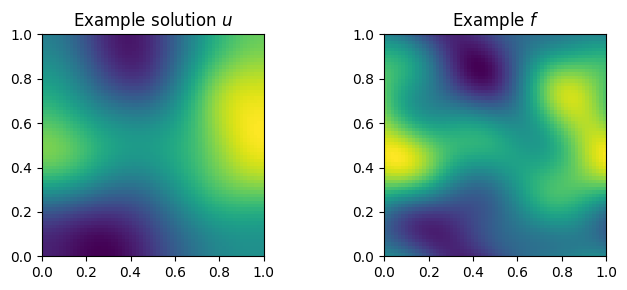

In [ ]:
save_path = "/localdata/komso/datasets/AllenCahn_data2"
output_f = torch.load(f"{save_path}/input_data.pt")
input_u = torch.load(f"{save_path}/output_data.pt")

print("Available data points:", len(input_u))
print("Shape of data:", input_u.shape)

# Plot one example of the data
plot_idx = 0

f, axarr = plt.subplots(1, 2, figsize=(7, 3))
axarr[0].imshow(input_u[plot_idx, :, :], origin='lower', extent=[0,1,0,1])
axarr[0].title.set_text(r"Example solution $u$")
axarr[1].imshow(output_f[plot_idx, :, :], origin='lower', extent=[0,1,0,1])
axarr[1].title.set_text(r"Example $f$")
plt.tight_layout()

The spaces are the same as always:

In [3]:
X = tp.spaces.R2("x")
F = tp.spaces.R1("f")
U = tp.spaces.R1("u")
fn_space_F = tp.spaces.FunctionSpace(X, F)
fn_space_U = tp.spaces.FunctionSpace(X, U)

In [4]:
# Split data into training and testing:
total_data = len(input_u)
train_N = int(0.9*total_data)

# TODO: Build the training and test set, as in the other examples
train_f = output_f[:train_N]
train_u = input_u[:train_N]

test_f = output_f[train_N:]
test_u = input_u[train_N:]

# TODO: Define the FunctionSets (Remeber that the roles of u and f are switched now!)
data_functionset_input = tp.domains.DataFunctionSet(fn_space_U, train_u)
data_functionset_output = tp.domains.DataFunctionSet(fn_space_F, train_f)

Next sampling as always:

In [5]:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(4000, data_functionset_input)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(data_functionset_output, functionsampler_input)

Now we have to choose the number of principal components for our input and output data. For the input $u$ we fix the number of PC to 30. 
Use the next cell to iteratively choose a fitting number of components for $f$, such that the smallest principal component is around the order $10^{-3}$.

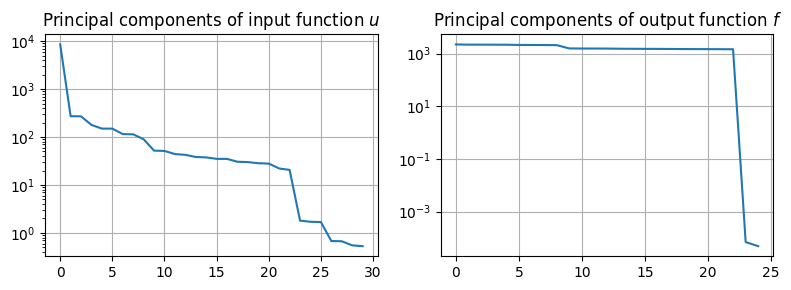

In [6]:
data_functionset_input.compute_pca(components=30)

# TODO: Find a fitting size of the PCA, such that the smallest components are in the order of 10^(-3).
data_functionset_output.compute_pca(components=25)


# We may want to analyze the size of the principal components:
_, S_in, _ = data_functionset_input.pca
_, S_out, _ = data_functionset_output.pca

f, axarr = plt.subplots(1, 2, figsize=(8, 3))
axarr[0].plot(S_in)
axarr[0].title.set_text(r"Principal components of input function $u$")
axarr[0].set_yscale("log")
axarr[0].grid()
axarr[1].plot(S_out)
axarr[1].title.set_text(r"Principal components of output function $f$")
axarr[1].set_yscale("log")
axarr[1].grid()
plt.tight_layout()

Then we define the network and data condition as before:

In [7]:
model = tp.models.PCANN_FC.from_fn_set(
    data_functionset_input, data_functionset_output, hidden=(50, 50, 50, 50)
)

data_condition = tp.conditions.OperatorCondition(module=model, 
                                                 input_function_sampler=functionsampler_input, 
                                                 output_function_sampler=functionsampler_output)

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.001,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 2000, "gamma":0.2})
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=10000, 
                    logger=False, 
                    callbacks=[RichProgressBar(refresh_rate=20, theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                    enable_checkpointing=False)

trainer.fit(solver)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [5]
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:256: Found unsupported keys in the lr scheduler dict: {'gamma', 'step_size'}. HINT: remove them from the output of `configure_optimizers`.

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.5 K
1 | val_conditions   | ModuleList | 0     
-------------------------

Epoch 0: 100%|██████████| 10000/10000 [00:56<00:00, 175.95it/s, train/loss=0.00285]

`Trainer.fit` stopped: `max_steps=10000` reached.


Epoch 0: 100%|██████████| 10000/10000 [00:56<00:00, 175.94it/s, train/loss=0.00285]


Finally, check the model on the test data:

In [9]:
model_output = model(test_u).as_tensor.detach()

rel_error = torch.norm(model_output - test_f, p=2, dim=(1,2,3))
rel_error /= torch.norm(test_f, p=2, dim=(1,2,3))
rel_error = torch.mean(torch.sqrt(rel_error))

print(f"Relative error: {rel_error*100} %")

Relative error: 22.305984497070312 %


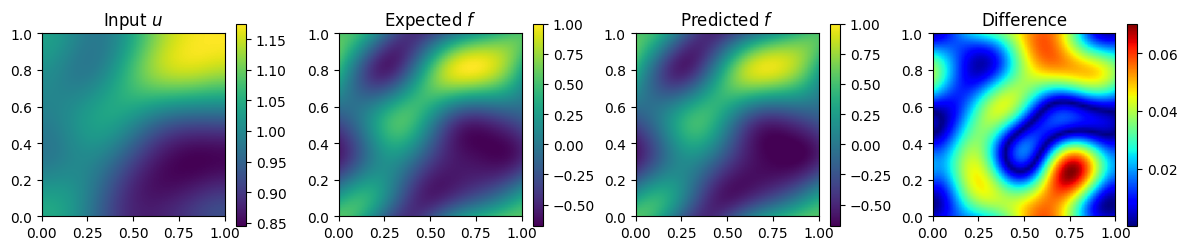

In [10]:
# Plot one example of the test data
plot_idx = 145


def plot_fn(plot_idx, test_f, test_u, model_output):
    _, axarr = plt.subplots(1, 4, figsize=(12, 3))

    vmin, vmax = torch.min(test_f[plot_idx]), torch.max(test_f[plot_idx])

    img = axarr[0].imshow(test_u[plot_idx, :, :], origin='lower', extent=[0,1,0,1])
    axarr[0].title.set_text(r"Input $u$")
    plt.colorbar(img, ax=axarr[0], shrink=0.75)

    img=axarr[1].imshow(test_f[plot_idx, :, :], vmin=vmin, vmax=vmax, origin='lower', extent=[0,1,0,1])
    axarr[1].title.set_text(r"Expected $f$")
    plt.colorbar(img, ax=axarr[1], shrink=0.75)

    img=axarr[2].imshow(model_output[plot_idx, :, :], vmin=vmin, vmax=vmax, origin='lower', extent=[0,1,0,1])
    axarr[2].title.set_text(r"Predicted $f$")
    plt.colorbar(img, ax=axarr[2], shrink=0.75)

    img=axarr[3].imshow(torch.abs(model_output[plot_idx, :, :]-test_f[plot_idx, :, :]), 
                    cmap="jet", origin='lower', extent=[0,1,0,1])
    axarr[3].title.set_text(r"Difference")
    plt.colorbar(img, ax=axarr[3], shrink=0.75)

    plt.tight_layout()

plot_fn(plot_idx, test_f, test_u, model_output)

This was now the case for non-noisy data. We could ask ourselfs, what happens if we only have noisy solution data $u$ available?
To this end let us test our model with noisy data:

Relative error: 34.953773498535156 %
Example plot:


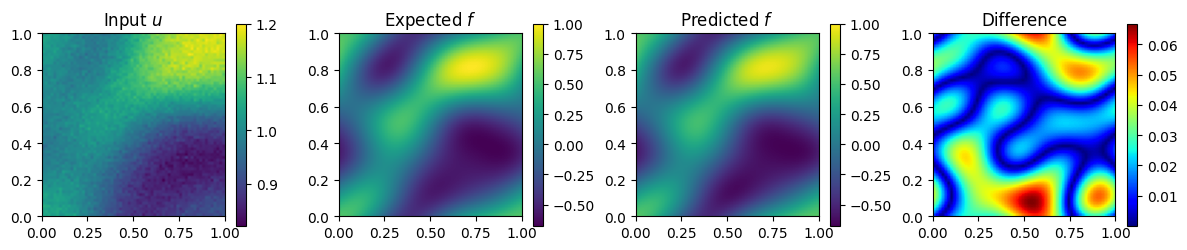

In [11]:
noise = 0.01*torch.randn_like(test_u)

model_output = model(test_u+noise).as_tensor.detach()

rel_error = torch.norm(model_output - test_f, p=2, dim=(1,2,3))
rel_error /= torch.norm(test_f, p=2, dim=(1,2,3))
rel_error = torch.mean(torch.sqrt(rel_error))

print(f"Relative error: {rel_error*100} %")
print("Example plot:")
plot_fn(plot_idx, test_f, test_u+noise, model_output)

We observe that our trained model is also stable when exposed to noise, thanks to the PCA!